**Завдання**
### Використовуючи бібліотеку **PyTorch**, створіть генеративно-змагагальну функцію (GAN) для генерації зображень цифр **MNIST**.

In [29]:
# Required libraries.
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

import warnings
warnings.simplefilter('ignore')

In [30]:
# Setting up the random generator seed.
torch.manual_seed(111)


In [31]:
# For using cuba device.
device = ''
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


## **Preparing and downloading a dataset**

In [32]:
# Preparing a data:
# Transforms.ToTensor() - converts the data to a PyTorch tensor.
# Transforms.Normalize() - converts the range of the tensor coefficients.
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)


In [34]:
# Downloading the data.
train_set = torchvision.datasets.MNIST(
    root="E:\Python DEVELOPER\StartUpAcademy\projects\lesson_55\DATA",
     train=True, download=True, transform=transform
)

# Batches of 32 samples.
batch_size = 32

# Creating a dataloader.
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True)

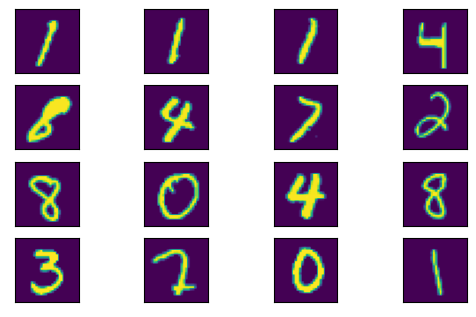

In [35]:
# Visualisation a real samples of the data.
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28))
    plt.xticks([])
    plt.yticks([])


## **The Generator and the Discriminator implementation**

In [36]:
# Making the Generator model with the ReLU activation function.
class Generator(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(), #  The output layer is activated by hyperbolic tangent function. 
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output


# Creating an instance of the Generator and running it.
generator = Generator().to(device=device)

In [37]:
# # Making the Discriminator model with the ReLU activation function.
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )


    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output


# Creating an instance of the Discriminator and running it.
discriminator = Discriminator().to(device=device)

## **Training the Models**

In [38]:
# Identification of the parameters of the model.
lr = 0.0001
num_epochs = 30
loss_function = nn.BCELoss() # Binary Crossentropy Loss function.

# Choosing the Adam optimizers for finding the best possible set of parameters.
# To minimize the loss between the predictions and the ground truth.
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)


### The training loop of the model:

In [39]:
# Creating the loop.
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):


        # Data for training the discriminator.
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)

        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)

        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator.
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )

        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator.
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

        # Training the generator.
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )

        loss_generator.backward()
        optimizer_generator.step()


        # The loss of the Generator and the Discriminator.
        if n == batch_size - 1:            
            print(f'Epoch: {epoch} | Loss the Generator: {loss_generator:.3f} | Loss the Discriminator: {loss_discriminator:.3f}')

Epoch: 0 | Loss the Generator: 0.552 | Loss the Discriminator: 0.541
Epoch: 1 | Loss the Generator: 4.350 | Loss the Discriminator: 0.122
Epoch: 2 | Loss the Generator: 4.810 | Loss the Discriminator: 0.009
Epoch: 3 | Loss the Generator: 7.453 | Loss the Discriminator: 0.173
Epoch: 4 | Loss the Generator: 3.910 | Loss the Discriminator: 0.075
Epoch: 5 | Loss the Generator: 3.399 | Loss the Discriminator: 0.096
Epoch: 6 | Loss the Generator: 3.103 | Loss the Discriminator: 0.117
Epoch: 7 | Loss the Generator: 5.616 | Loss the Discriminator: 0.080
Epoch: 8 | Loss the Generator: 7.585 | Loss the Discriminator: 0.003
Epoch: 9 | Loss the Generator: 54.139 | Loss the Discriminator: 0.000
Epoch: 10 | Loss the Generator: 51.663 | Loss the Discriminator: 0.000
Epoch: 11 | Loss the Generator: 70.917 | Loss the Discriminator: 0.000
Epoch: 12 | Loss the Generator: 70.439 | Loss the Discriminator: 0.000
Epoch: 13 | Loss the Generator: 74.016 | Loss the Discriminator: 0.000
Epoch: 14 | Loss the Gene

## **The result generated by the GAN Model after 30 epochs**

In [40]:
# Choosing a random samples from the model for feeding to the generator.
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

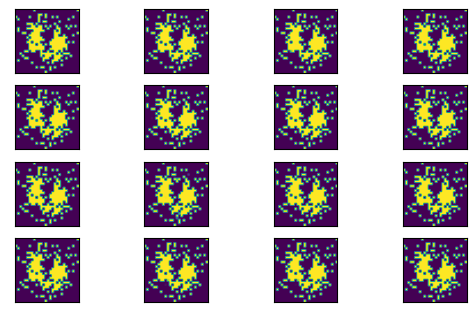

In [42]:
# Visualization of the generated result.
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28))
    plt.xticks([])
    plt.yticks([])
